In [1]:
# %matplotlib notebook

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import math
from scipy import stats

import Floyd.scripts.commons.utils as utils

In [2]:
root_folder = "./LSTM_ngram/checkpoints/"
root_wavs_dir = "./Database/TIMIT/TRAIN"
checkpoints_folder = "./EDA/checkpoint/"

assert os.path.isdir(root_wavs_dir)

#get all data files
wav_files = glob.glob(root_wavs_dir + "/*/*/*.wav")
phn_files = glob.glob(root_wavs_dir + "/*/*/*.PHN")

#test if it is correct
assert (len(wav_files) > 0) and (len(phn_files) > 0)
assert len(wav_files) == len(phn_files)

n_files = len(wav_files)

print("Found " + str(n_files) + " wavs and .phn files ")
print(phn_files[500])

Found 4620 wavs and .phn files 
./Database/TIMIT/TRAIN\DR2\FLMA0\SA1.PHN


In [3]:
# train_df = pd.read_pickle(root_folder + "train_df.pkl")
# test_df = pd.read_pickle(root_folder + "test_df.pkl")

In [4]:
NFFT = 512

def read_phons(phn_file):
    phn_list = []
    for line in open(phn_file):
        elems = line.split(" ")
        phn_list.append({"start": int(elems[0]), "end": int(elems[1]), "phn": elems[2].rstrip()})
    return phn_list

def calc_energy(wav): #TODO: probar también con energía espectral, máximo, etc
    energy = np.sum(np.abs(wav)**2)/len(wav)
    complex_spec = np.fft.rfft(wav, NFFT)
    power_spec =  1.0 / NFFT * np.square(np.abs(complex_spec))
    return energy, complex_spec, power_spec

def extract_phons(wav, phns_list):
    phns_df = pd.DataFrame(columns = ["wav", "scanlon", "reynolds", "phon", "reduced", "energy", "complex_energy", "power_spec"])
    for phn in phns_list:
        phn_wav = wav[int(phn["start"]):int(phn["end"]+1)]
        phn_label = phn["phn"]
        collapsed = utils.reduce_labels(phn_label, input_index = False, output_index = False)
        scanlon = utils.labels_to_category(collapsed, category_type = "scanlon", input_index = False, output_index = False)
        reynolds = utils.labels_to_category(collapsed, category_type = "reynolds", input_index = False, output_index = False)
        standard = utils.labels_to_category(collapsed, category_type = "standard", input_index = False, output_index = False) 
        energy, complex_spec, power_spec = calc_energy(phn_wav)
        
        phns_df = phns_df.append({"wav": phn_wav, "scanlon": scanlon, "reynolds":reynolds, "standard": standard, 
                                  "phon": phn_label, "reduced": collapsed,
                                  "energy": energy, "complex_energy": complex_spec, "power_spec": power_spec},
                                                                                          ignore_index = True)
    return phns_df

def create_dict(phns_files):
    _phns_df = pd.DataFrame(columns = ["wav", "scanlon", "reynolds", "standard", "phon", "reduced", "energy", "complex_energy", "power_spec"])
    for phn_file in phns_files:
        wav_file = phn_file[:-4] + "RIFF.wav"
        wav,_ = utils.read_wav(wav_file)
        phns_list = read_phons(phn_file)
        _phns_df = _phns_df.append(extract_phons(wav, phns_list), ignore_index = True)
    return _phns_df

In [5]:
#Read phonemes DataFrame, create if it doesn't exists
phns_df_file = os.path.join(checkpoints_folder, "phns_df.pkl")
if os.path.isfile(phns_df_file):
    phns_df = pd.read_pickle(phns_df_file)
else:    
    phns_df = create_dict(phn_files)
    pd.to_pickle(phns_df, path = phns_df_file)

#Select only a few samples to speed up the process
# def create_samples_df(df, n = 500):
#     samples_df = pd.DataFrame(columns = df.columns)
#     for p in df["phon"].unique():
#         to_append = df[df["phon"]== p].sample(n=n)
#         samples_df = samples_df.append(to_append, ignore_index=True)
#     return samples_df

phns_df.head(5)

,complex_energy,energy,phon,power_spec,reduced,reynolds,scanlon,standard,wav
0,"[(0.4949820788530466+0j), (-0.0273889489413525...",0.000002,h#,"[0.0004785298015345384, 2.167903581664308e-06,...",sil,closures,silences,stop,"[0.00035842293906810036, -0.000358422939068100..."
1,"[(0.17168458781362+0j), (-0.019602066445342306...",0.002161,sh,"[5.756952674361836e-05, 1.0768323301669352e-05...",sh,fricatives,fricatives,fricative,"[0.0060931899641577065, 0.0, 0.004301075268817..."
2,"[(-0.04408602150537602+0j), (0.239542155910104...",0.009489,ix,"[3.7960493987743694e-06, 0.0001129090919093058...",ih,vowels,vowels,vowel,"[-0.01827956989247312, -0.015412186379928316, ..."
3,"[(-0.5240143369175625+0j), (-0.675118595390058...",0.004229,hv,"[0.0005363105962795952, 0.001004562563889021, ...",h,fricatives,fricatives,semivowel,"[-0.01935483870967742, -0.013620071684587814, ..."
4,"[(1.9985663082437268+0j), (2.2951317805884024+...",0.077595,eh,"[0.007801303297747968, 0.010289247859897337, 0...",eh,vowels,vowels,vowel,"[0.0064516129032258064, 0.017204301075268817, ..."


In [16]:
phns_df = phns_df[~phns_df.phon.isin(["h#", "pau", "epi"])]
phns_df = phns_df[~phns_df.scanlon.isin(["none"])]

phns_df.head(5)

,complex_energy,energy,phon,power_spec,reduced,reynolds,scanlon,standard,wav,len,argmax_spec
1,"[(0.17168458781362+0j), (-0.019602066445342306...",0.002161,sh,"[5.756952674361836e-05, 1.0768323301669352e-05...",sh,fricatives,fricatives,fricative,"[0.0060931899641577065, 0.0, 0.004301075268817...",1510,134
2,"[(-0.04408602150537602+0j), (0.239542155910104...",0.009489,ix,"[3.7960493987743694e-06, 0.0001129090919093058...",ih,vowels,vowels,vowel,"[-0.01827956989247312, -0.015412186379928316, ...",1165,15
3,"[(-0.5240143369175625+0j), (-0.675118595390058...",0.004229,hv,"[0.0005363105962795952, 0.001004562563889021, ...",h,fricatives,fricatives,semivowel,"[-0.01935483870967742, -0.013620071684587814, ...",920,7
4,"[(1.9985663082437268+0j), (2.2951317805884024+...",0.077595,eh,"[0.007801303297747968, 0.010289247859897337, 0...",eh,vowels,vowels,vowel,"[0.0064516129032258064, 0.017204301075268817, ...",2131,25
5,"[(-0.12258064516129034+0j), (-0.18089279442284...",0.000663,dcl,"[2.9347684703433934e-05, 9.440738540295386e-05...",sil,closures,silences,stop,"[-0.03763440860215054, -0.052329749103942655, ...",419,7


### Distribución de los fonemas por clase y por tamaño

D:\Programs\Anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



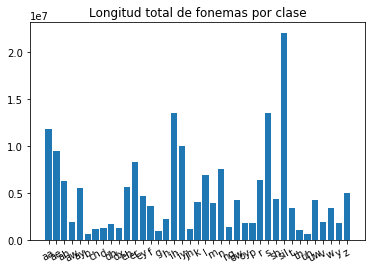

In [17]:
to_plot = pd.DataFrame(columns = ["reduced", "num_phons", "phon_len"])

for a,df in phns_df.groupby("reduced"):
    df["phon_len"] = df["wav"].apply(len)
                                 
    to_plot = to_plot.append({"reduced": df.iloc[0]["reduced"], "num_phons": len(df), "phon_len": df["phon_len"].sum()},
                              ignore_index = True)

def barplot(df, y_col, x_col, title = None, xlabel = None, ylabel = None, normalize = False): 
    index = np.arange(len(to_plot))
    plt.bar(index, to_plot[y_col])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.xticks(index, to_plot[x_col], rotation=30)
    plt.title(title)
    plt.show()

barplot(to_plot, y_col = "phon_len", x_col = "reduced", title = "Longitud total de fonemas por clase",
        xlabel = None, ylabel = None, normalize = True)

### Comporbamos si hay diferencia en el tamaño de ventana por clases

In [20]:
to_plot = pd.DataFrame(columns = ["mean", "std", "category"])
for df_group in phns_df.groupby("standard"):
    df = df_group[1]
#     df["data"] = df["power_spec"].apply(np.argmax)
    df["data"] = df["wav"].apply(len)
    mean = df["data"].mean()
    std = df["data"].std()
    category = df_group[0]
    
    to_plot = to_plot.append({"mean": mean, "std": std, "category": category} ,ignore_index = True)

D:\Programs\Anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



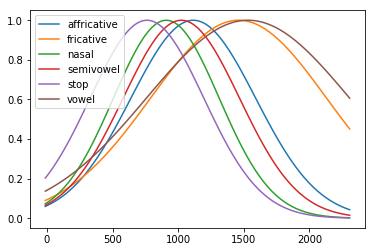

In [21]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

x_values = np.linspace(to_plot["mean"].min() - to_plot["std"].max(), 
                       to_plot["mean"].max() + to_plot["std"].max(), 120)

for ix,row in to_plot.iterrows():
    plt.plot(x_values, gaussian(x_values, row["mean"], row["std"]), label = row["category"])

plt.legend(loc='upper left')
plt.show()

In [66]:
# phns_df["len"].max()
# phns_df.iloc[38346]
# plt.plot(phns_df.iloc[38346]["wav"])
# plt.show()
# phns_df["len"] = phns_df["wav"].apply(len)
# phns_df = phns_df.drop(phns_df[phns_df["phon"].isin(["sil"])])
# phns_df[phns_df["phon"].isin(["sil"])]["len"].max()
def is_outlier(points, thresh=3.5):
    """
    Returns a boolean array with True if points are outliers and False 
    otherwise.

    Parameters:
    -----------
        points : An numobservations by numdimensions array of observations
        thresh : The modified z-score to use as a threshold. Observations with
            a modified z-score (based on the median absolute deviation) greater
            than this value will be classified as outliers.

    Returns:
    --------
        mask : A numobservations-length boolean array.

    References:
    ----------
        Boris Iglewicz and David Hoaglin (1993), "Volume 16: How to Detect and
        Handle Outliers", The ASQC Basic References in Quality Control:
        Statistical Techniques, Edward F. Mykytka, Ph.D., Editor. 
    """
    if len(points.shape) == 1:
        points = points[:,None]
    median = np.median(points, axis=0)
    diff = np.sum((points - median)**2, axis=-1)
    diff = np.sqrt(diff)
    med_abs_deviation = np.median(diff)

    modified_z_score = 0.6745 * diff / med_abs_deviation

    return modified_z_score > thresh

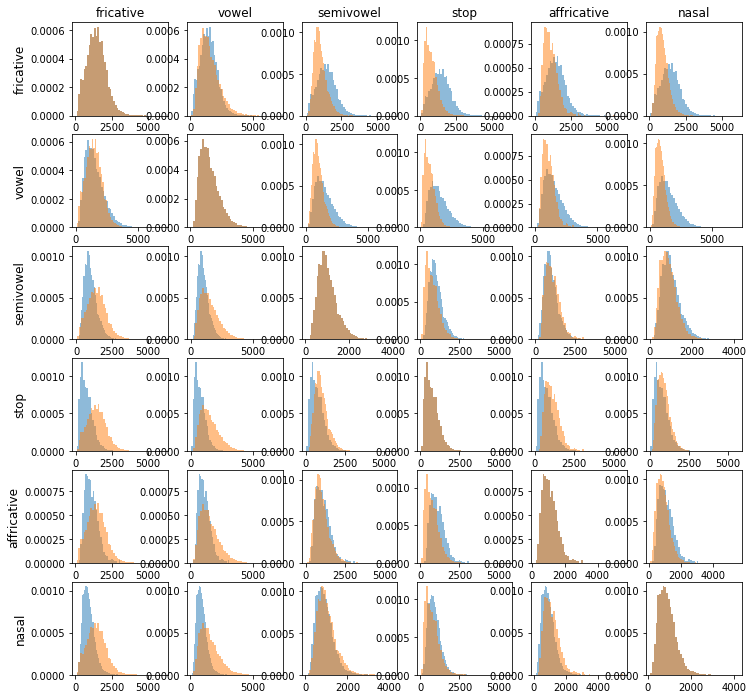

In [22]:
def hist_matrix(target = "category", labels = [], feat="energy", df = phns_df, figsize = (12,12)):
    if labels != []:
        df = df[df[target].isin(labels)]

    labels = df[target].unique()

    fig,axes = plt.subplots(len(labels), len(labels), figsize = figsize, sharex=False, sharey=False)

    for ax, col in zip(axes[0], labels):
        ax.set_title(col)

    for ax, row in zip(axes[:,0], labels):
        ax.set_ylabel(row, rotation=90, size='large')

    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
#             df[category]==labels[col]
            axes[row,col].hist(df[df[target]==labels[row]][feat], bins=50, alpha=0.5, density = True)
            axes[row,col].hist(df[df[target]==labels[col]][feat], bins=50, alpha=0.5, density = True)

    plt.show()

phns_df["len"] = phns_df["wav"].apply(len)

#ELIMINO LOS OUTLIERS
# phns_df.drop(phns_df.index[[51695]], inplace=True)

hist_matrix("standard", [], "len", phns_df)

### Dónde si hay diferencia es en el argmax del power spectrum

In [23]:
to_plot = pd.DataFrame(columns = ["mean", "std", "category"])
for df_group in phns_df.groupby("standard"):
    df = df_group[1]
    df["data"] = df["power_spec"].apply(np.argmax)
    mean = df["data"].mean()
    std = df["data"].std()
    category = df_group[0]
    
    to_plot = to_plot.append({"mean": mean, "std": std, "category": category} ,ignore_index = True)

D:\Programs\Anaconda3\envs\machine_learning\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



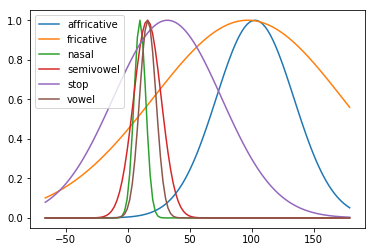

In [24]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

x_values = np.linspace(to_plot["mean"].min() - to_plot["std"].max(), 
                       to_plot["mean"].max() + to_plot["std"].max(), 120)

for ix,row in to_plot.iterrows():
    plt.plot(x_values, gaussian(x_values, row["mean"], row["std"]), label = row["category"])

plt.legend(loc='upper left')
plt.show()

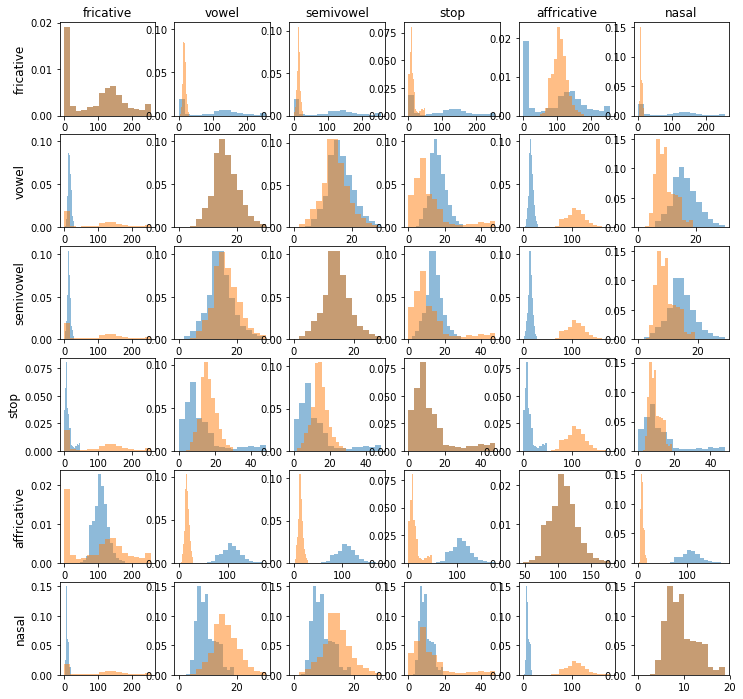

In [85]:
def hist_matrix(target = "category", labels = [], feat="energy", df = phns_df, figsize = (12,12)):
    if labels != []:
        df = df[df[target].isin(labels)]

    labels = df[target].unique()

    fig,axes = plt.subplots(len(labels), len(labels), figsize = figsize, sharex=False, sharey=False)
#     plt.ylim(0, 0.03)
#     plt.xlim(0,0.07)

    for ax, col in zip(axes[0], labels):
        ax.set_title(col)

    for ax, row in zip(axes[:,0], labels):
        ax.set_ylabel(row, rotation=90, size='large')
        
    for row in range(axes.shape[0]):
        row_feats = df[df[target]==labels[row]][feat]
        row_feats = row_feats[~is_outlier(row_feats)]
        for col in range(axes.shape[1]):
            col_feats = df[df[target]==labels[col]][feat]
            col_feats = col_feats[~is_outlier(col_feats)]
            
            axes[row,col].hist(row_feats, bins=15, alpha=0.5, density = True)
            axes[row,col].hist(col_feats, bins=15, alpha=0.5, density = True)

    plt.show()

phns_df["argmax_spec"] = phns_df["power_spec"].apply(np.argmax)
hist_matrix("standard", [], "argmax_spec", phns_df)

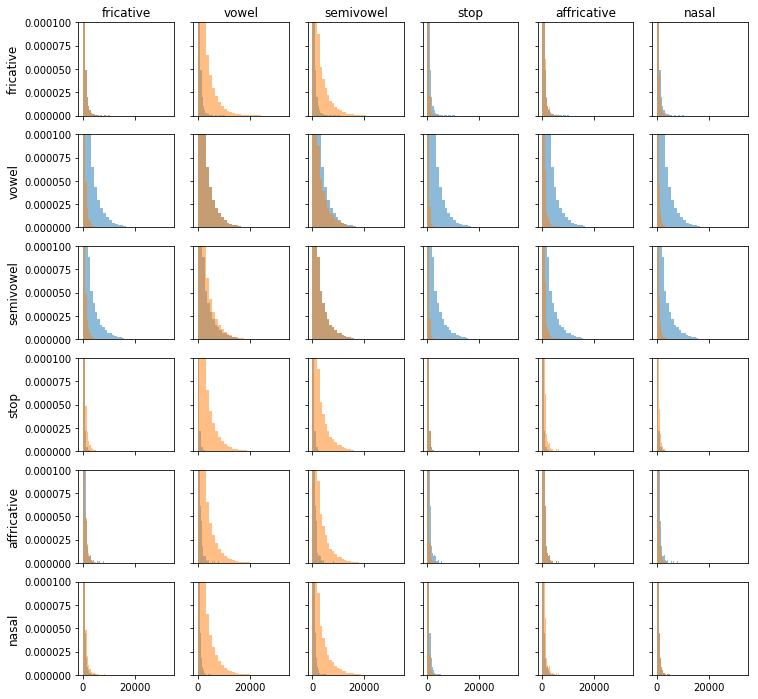

In [64]:
def hist_matrix(target = "category", labels = [], feat="energy", df = phns_df, figsize = (12,12)):
    if labels != []:
        df = df[df[target].isin(labels)]

    labels = df[target].unique()

    fig,axes = plt.subplots(len(labels), len(labels), figsize = figsize, sharex=True, sharey=True)
    plt.ylim(0, 0.0001)
#     plt.xlim(0,17000)

    for ax, col in zip(axes[0], labels):
        ax.set_title(col)

    for ax, row in zip(axes[:,0], labels):
        ax.set_ylabel(row, rotation=90, size='large')
        
    for row in range(axes.shape[0]):
        for col in range(axes.shape[1]):
#             df[category]==labels[col]
            axes[row,col].hist(df[df[target]==labels[row]][feat], bins=30, alpha=0.5, density = True)
            axes[row,col].hist(df[df[target]==labels[col]][feat], bins=30, alpha=0.5, density = True)

    plt.show()

phns_df["spectral_energy"] = phns_df["complex_energy"].apply(lambda x: np.sum(np.abs(x)**2))
hist_matrix("standard", [], "spectral_energy", phns_df)